In [147]:
import pandas as pd
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import numpy as np

In [148]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Predict fraud probabilities")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "8g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [149]:
#spark.read.parquet('../../../data/curated/process_data.parquet').printSchema()

In [150]:
# these are our predictors
base_features = {'dollar_value',
                 'gender',
                 'revenue',
                 'rate'}

#user_feature = {'user_fraud_probability'}
#merchant_feature = {'merchant_fraud_probability'}

target_features = {'user_fraud_probability', 'merchant_fraud_probability'}


subset = base_features.union(target_features)
print(subset)

{'rate', 'dollar_value', 'merchant_fraud_probability', 'gender', 'user_fraud_probability', 'revenue'}


In [151]:
data = spark.read.parquet('../../../data/curated/process_data.parquet').select(*subset)
#user_data = data.na.drop(subset=['user_fraud_probab
# ility'])
#merchant_data = data.na.drop(subset=['merchant_fraud_probability'])

In [152]:
def get_weights(df1, label, n):

    # drop rows with missing label
    df = df1.na.drop(subset=[label]).toPandas()

    # find bins
    df['bin'] = pd.cut(df[label], n)

    # get weights and create mapper
    d = df.groupby('bin').count()[label].map(np.log)
    d = d.sum() / d
    mapper = d.to_dict()

    # create weights col mapped from bins
    df['weights'] = df['bin'].map(lambda x: mapper[x])

    weighted_df = spark.createDataFrame(df.drop('bin', axis=1))

    return weighted_df


In [153]:
ud = get_weights(data, 'user_fraud_probability', 10)

In [154]:
md = get_weights(data, 'merchant_fraud_probability', 5)

In [155]:
md.limit(10)

rate,dollar_value,merchant_fraud_probability,gender,user_fraud_probability,revenue,weights
0.0273,727.31,0.3,Male,NaN,c,2.5125695633550493
0.061,315.11,0.29,Male,NaN,a,2.5125695633550493
0.0273,179.11,0.3,Male,NaN,c,2.5125695633550493
0.0664,31.93,0.28,Female,NaN,a,2.5125695633550493
0.0555,857.35,0.29,Female,NaN,a,2.5125695633550493
0.0176,376.61,0.29,Male,NaN,c,2.5125695633550493
0.0273,462.39,0.3,Male,NaN,c,2.5125695633550493
0.0273,35.23,0.3,Male,NaN,c,2.5125695633550493
0.0419,30489.85,0.3,Female,0.52,b,2.5125695633550493
0.061,230.97,0.29,Female,NaN,a,2.5125695633550493


In [156]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                               outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                          + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data_ = model.transform(df)

    return data_.select('features',labelCol, 'weights')

In [157]:
# now we want to vectorize
categorical_cols = {'gender','revenue'}
continous_cols = {'dollar_value', 'rate'}

In [158]:
ud_v = get_dummy(ud, list(categorical_cols), list(continous_cols), labelCol='user_fraud_probability')
md_v = get_dummy(md, list(categorical_cols), list(continous_cols), labelCol='merchant_fraud_probability')

In [159]:
md_v.show(10)
#md_v.orderBy(F.desc('weights'))

+--------------------+--------------------------+------------------+
|            features|merchant_fraud_probability|           weights|
+--------------------+--------------------------+------------------+
|(8,[1,4,6,7],[1.0...|                       0.3|2.5125695633550493|
|(8,[1,2,6,7],[1.0...|                      0.29|2.5125695633550493|
|(8,[1,4,6,7],[1.0...|                       0.3|2.5125695633550493|
|(8,[0,2,6,7],[1.0...|                      0.28|2.5125695633550493|
|(8,[0,2,6,7],[1.0...|                      0.29|2.5125695633550493|
|(8,[1,4,6,7],[1.0...|                      0.29|2.5125695633550493|
|(8,[1,4,6,7],[1.0...|                       0.3|2.5125695633550493|
|(8,[1,4,6,7],[1.0...|                       0.3|2.5125695633550493|
|(8,[0,3,6,7],[1.0...|                       0.3|2.5125695633550493|
|(8,[0,2,6,7],[1.0...|                      0.29|2.5125695633550493|
+--------------------+--------------------------+------------------+
only showing top 10 rows



In [160]:
gbt_uf = GBTRegressor(labelCol='user_fraud_probability',
                   featuresCol="features",
                   maxIter=20,
                   maxDepth=10,
                   seed=56,
                   lossType='squared',
                   weightCol='weights',
                   predictionCol='user_fraud_prediction')

In [161]:
gbt_mf = GBTRegressor(labelCol='merchant_fraud_probability',
                   featuresCol="features",
                   maxIter=20,
                   maxDepth=10,
                   seed=56,
                   lossType='squared',
                   weightCol='weights',
                   predictionCol='merchant_fraud_prediction')

In [162]:
(ufTrainData, ufTestData) = ud_v.randomSplit([0.7, 0.3])
(mfTrainData, mfTestData) = md_v.randomSplit([0.7, 0.3])

Fit the models

In [163]:
uf_model = gbt_uf.fit(ufTrainData)

22/10/06 16:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1023.5 KiB
22/10/06 16:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1016.5 KiB
22/10/06 16:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB
22/10/06 16:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB
22/10/06 16:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1018.7 KiB
22/10/06 16:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1021.0 KiB
22/10/06 16:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB
22/10/06 16:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1035.3 KiB
22/10/06 16:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1049.9 KiB
22/10/06 16:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1070.2 KiB
22/10/06 16:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1099.3 KiB
22/10/06 16:13:26 WAR

In [164]:
mf_model = gbt_mf.fit(mfTrainData)

Evaluate model on training data

In [165]:
uf_predictions = uf_model.transform(ufTrainData)

In [166]:
mf_predictions = mf_model.transform(mfTrainData)

In [124]:
#mf_predictions

In [167]:
uf_res = uf_predictions.select(['user_fraud_prediction', 'user_fraud_probability']).toPandas()
mf_res = mf_predictions.select(['merchant_fraud_prediction', 'merchant_fraud_probability']).toPandas()

User fraud predictions on training data

<AxesSubplot:>

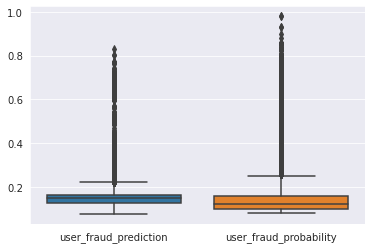

In [168]:
sns.boxplot(data=uf_res)

<AxesSubplot:xlabel='user_fraud_prediction', ylabel='Count'>

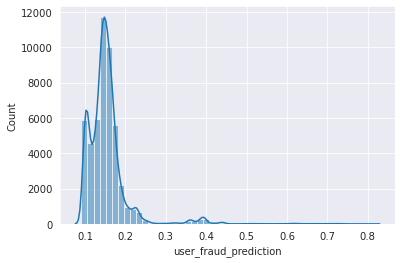

In [169]:
sns.histplot(x='user_fraud_prediction', data=uf_res, kde=True, bins=50)

<AxesSubplot:xlabel='user_fraud_probability', ylabel='Count'>

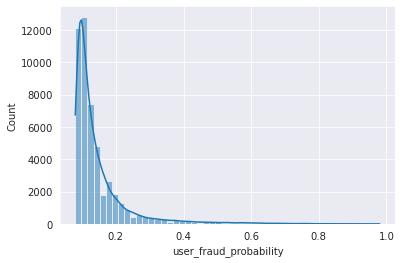

In [170]:
sns.histplot(uf_res['user_fraud_probability'], kde=True, bins=50)

User fraud predctions on test data

In [172]:
uf_pred_test = uf_model.transform(ufTestData)

uf_res_test = uf_pred_test.select(['user_fraud_prediction', 'user_fraud_probability']).toPandas()

<AxesSubplot:>

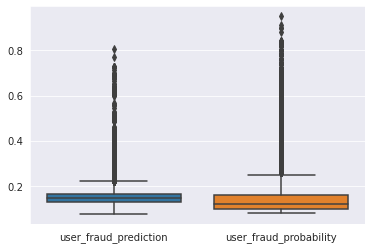

In [173]:
sns.boxplot(data=uf_res_test)

<AxesSubplot:xlabel='user_fraud_prediction', ylabel='Count'>

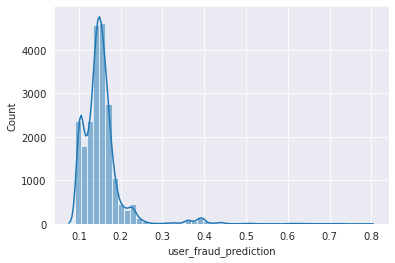

In [174]:
sns.histplot(x='user_fraud_prediction', data=uf_res_test, kde=True, bins=50)

<AxesSubplot:xlabel='user_fraud_probability', ylabel='Count'>

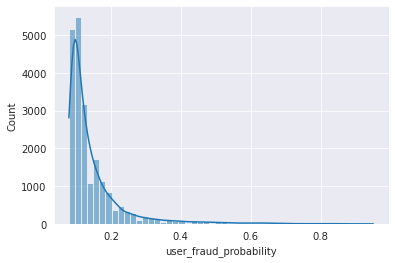

In [175]:
sns.histplot(uf_res_test['user_fraud_probability'], kde=True, bins=50)

Merchant fraud predictions on training data

<AxesSubplot:>

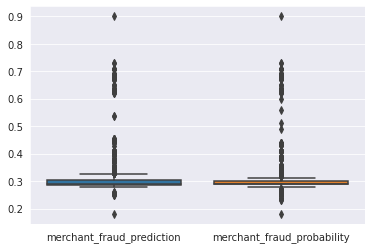

In [176]:
sns.boxplot(data=mf_res)

<AxesSubplot:xlabel='merchant_fraud_prediction', ylabel='Count'>

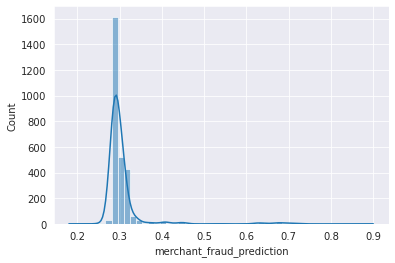

In [177]:
sns.histplot(x='merchant_fraud_prediction', data=mf_res    , kde=True, bins=50)

<AxesSubplot:xlabel='merchant_fraud_probability', ylabel='Count'>

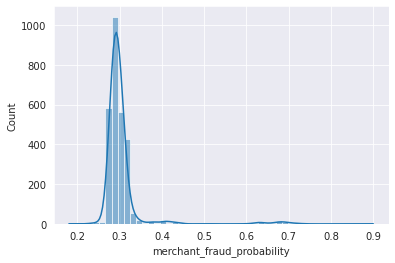

In [178]:
sns.histplot(mf_res['merchant_fraud_probability'], kde=True, bins=50)

Merchant fraud predictions on test data

In [179]:
mf_pred_test = mf_model.transform(mfTestData)
mf_res_test = mf_pred_test.select(['merchant_fraud_prediction', 'merchant_fraud_probability']).toPandas()


<AxesSubplot:>

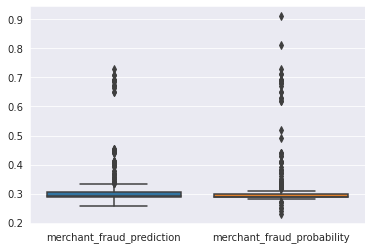

In [180]:
sns.boxplot(data=mf_res_test)

<AxesSubplot:xlabel='merchant_fraud_prediction', ylabel='Count'>

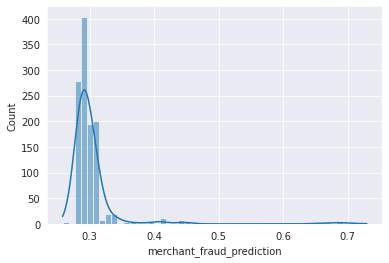

In [181]:
sns.histplot(x='merchant_fraud_prediction', data=mf_res_test, kde=True, bins=50)

<AxesSubplot:xlabel='merchant_fraud_probability', ylabel='Count'>

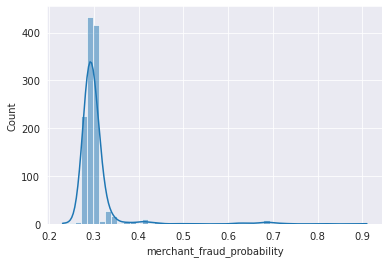

In [182]:
sns.histplot(x='merchant_fraud_probability', data=mf_res_test, kde=True, bins=50)

TODO:
* Add RMSE / AMSE calculations
* Apply to entire dataset

In [133]:
# apply to entire dataset

# now I have to vectorize the entire dataset... ->
# -> then apply the model.transform

In [ ]:
#o_res =